# Topo SparseDream with Lateral Inhibition

## Intro
* **Date**: 12/14/2020
* **What**: This is a SparseDream network with both lateral excitation and lateral inhibition.  So basically, I'm trying to form horizontal topological connections within the feature map, but I'm also trying to form vertical 1d manifolds for features.
* **Why**: Because topography is everything, and invariance is the key.  The lateral excitation allows the network to organize the features according to which ones are related, and the lateral inhibition a) keeps the network from firing all at once, and b) creates vertical competition which hopefully promotes the formation of vertical manifolds.  At least that's the hope.
* **Hopes**: As I've already made clear, I want topological connections in the horizontal direction and manifolds in the vertical direction.  
* **Limitations**: I'm not sure.  In the last experiment, lateral inhibition was being a little tricky and finicky.  I'm going to have to be careful about hyperparameter tuning.  Especially `gamma`.  `gamma` seems to be very important. And I mean, everything could break.  That's always a possibility.  

## Technicals
I'm going to start out with mnist because I think I hopefully will be able to see evidence of both topological connections and manifold formation.

Also, I should be clear.  When I talk about manifolds, I'm really talking about learning configurations of inputs that are similar, but slightly different.  Ie, the network has to choose between one of several options for a particular feature. The trick is getting the features that are most similar to be next to one other in the feature map.  

You know what?  I'm must going to call the feature map the feature space from now on. It's the space of all learned features.

So yeah, that's what I mean by manifolds.

## Code

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from scipy.special import expit as sig

(train_x, train_y), (test_x, test_y) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


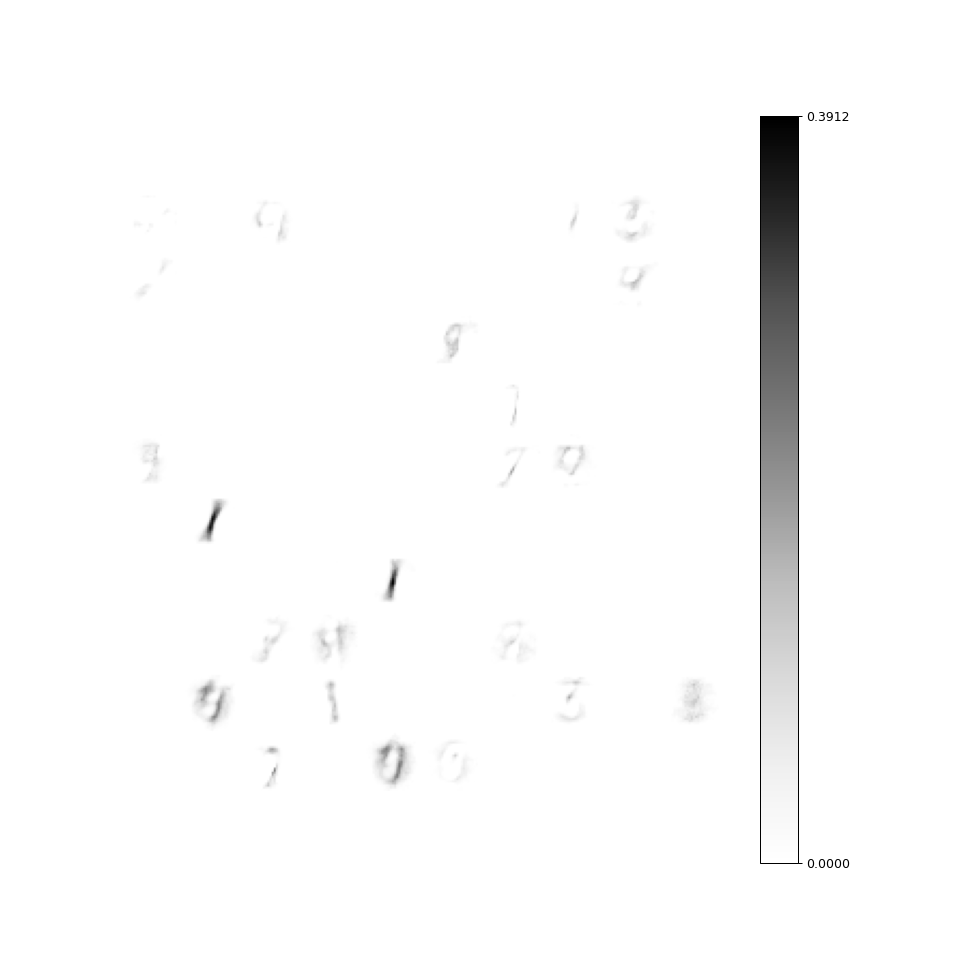

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1212.10it/s]


In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 1    # Vertical neighbor max distance
x_ex = 3    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.1, 1, (N, N))
lat_ex *= lat_ex_mask

alpha = 0.02

# Initialize global inhibition
g_lat_in = np.random.uniform(0.1, 1, (N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.0005

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.random.uniform(0.1, 1, (N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.02 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 1
sp = 0.05
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
c        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ o
        mod_o_r = np.maximum(o_r, prec)
        o_e = o - o_r
        
        lat_ex += lat_ex * o * (o_e / mod_o_r).T * alpha
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

## Analysis Dialog

You see that shit?  I got my work cut out for me. I'm going to run this a couple times with different parameters set to zero until I can figure out how to bring each one in naturally.  

<IPython.core.display.Javascript object>


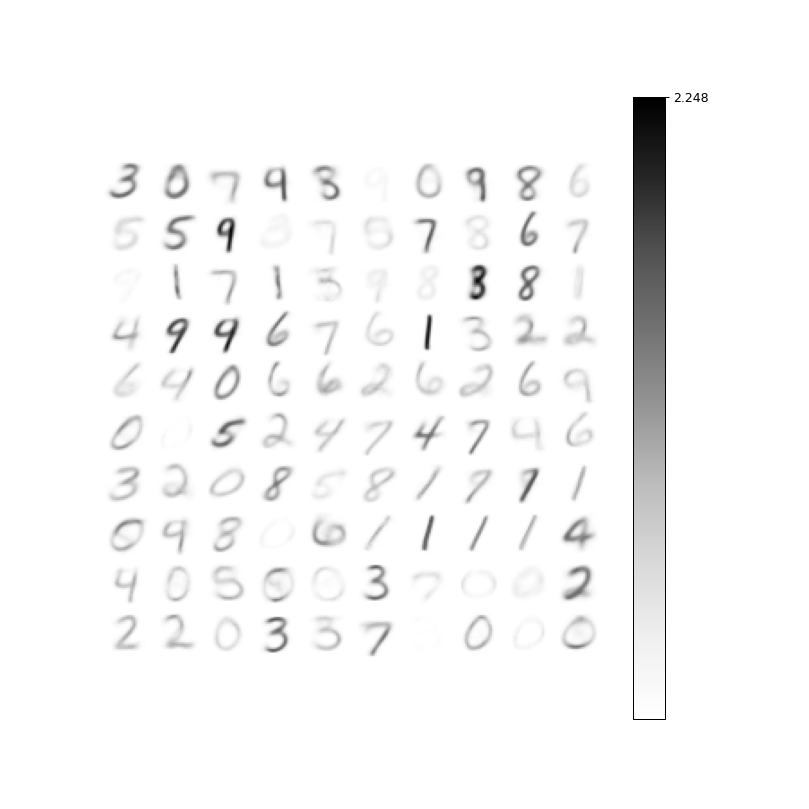

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1225.48it/s]


In [57]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 1    # Vertical neighbor max distance
x_ex = 3    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.0005

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.01
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
#         o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
        o = sig(w_v +((lat_ex - g_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ o
        mod_o_r = np.maximum(o_r, prec)
        o_e = o - o_r
        
        lat_ex += lat_ex * o * (o_e / mod_o_r).T * alpha
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

I have discovered something very interesting.  If you train the lateral excitation on the output of the hidden layer (as I have been doing), then if one neuron dominates another with a lateral excitatory synapse, then the dominated neuron will fade away. Put differently, the main input to the dominated neuron is from the dominator, so you end up getting the neurons firing in a correlated fashion simply because one neuron is driving the other.  

This effect is more evident when I make the sparsity higher, but you can still definitely see it in the above network.  Lateral inhibition was supposed to take care of that, but it super didn't, so whatever.  

I'm going to try this again, but training the lateral excitation only on the feed-forward output.

<IPython.core.display.Javascript object>


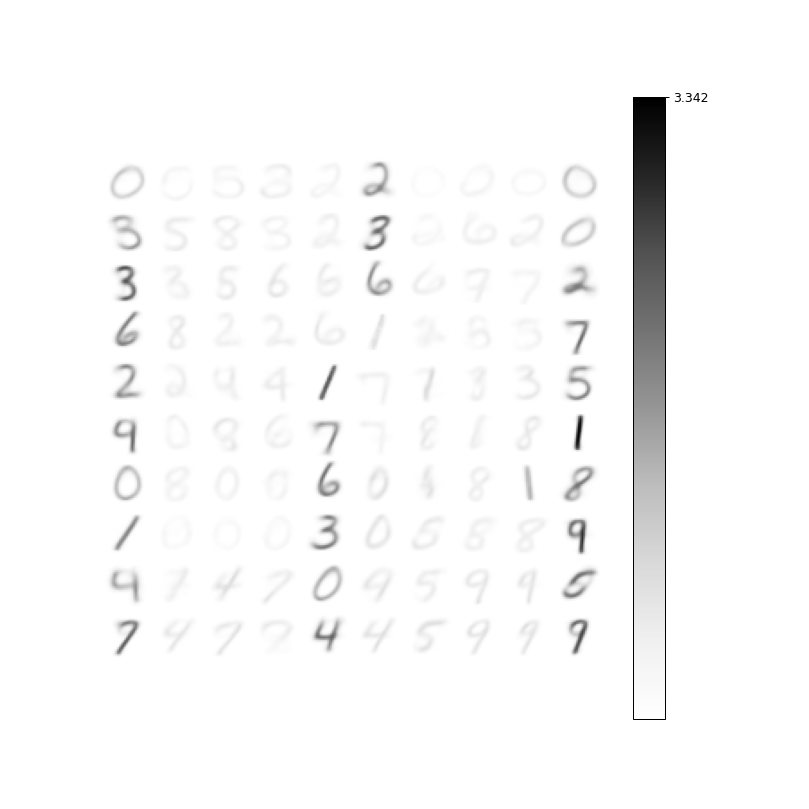

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1204.66it/s]


In [58]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 1    # Vertical neighbor max distance
x_ex = 3    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.0005

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.01
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        ff = sig(w_v - t)
#         o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
        o = sig(w_v +((lat_ex - g_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ ff
        mod_o_r = np.maximum(o_r, prec)
        o_e = ff - o_r
        
        lat_ex += lat_ex * ff * (o_e / mod_o_r).T * alpha
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

Now, *that* is fascinating.  So basically, we're seeing the exact same effect again, but it's much more evident.  I did not expect that.  But it's kinda awesome that it's in lines, because you can see the effect of lateral excitation much more clearly.

Now, the question is, how do we escape that?  

<IPython.core.display.Javascript object>


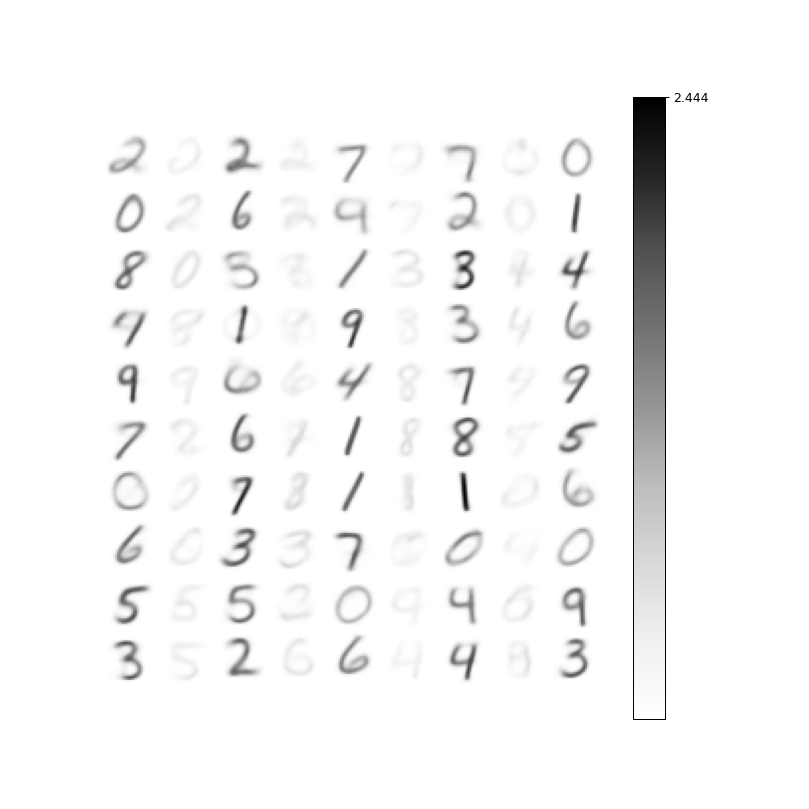

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1595.31it/s]


In [65]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 9
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 1    # Vertical neighbor max distance
x_ex = 1    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.001

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.01
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        ff = sig(w_v - t)
#         o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
        o = sig(w_v +((lat_ex - g_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ ff
        mod_o_r = np.maximum(o_r, prec)
        o_e = ff - o_r
        
        lat_ex += lat_ex * ff * (o_e / mod_o_r).T * alpha
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

Dang.  This dominating effect is straight-up not great.  I'm going to throw back in manifold inhibition and see if that helps at all.

<IPython.core.display.Javascript object>


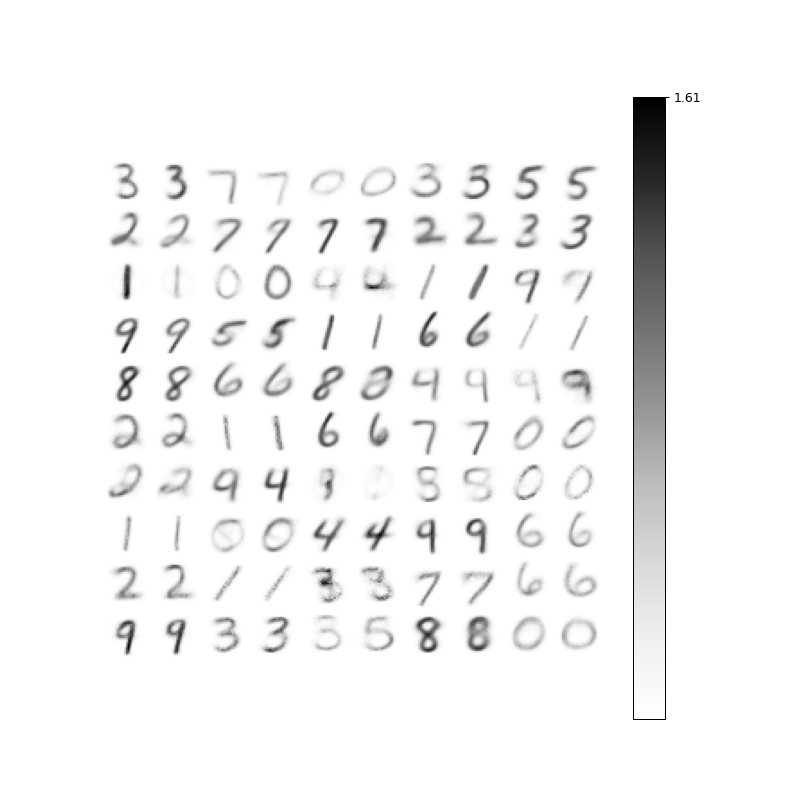

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1180.98it/s]


In [81]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 0    # Vertical neighbor max distance
x_ex = 1    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.001

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.01
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        ff = sig(w_v - t)
        o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
#         o = sig(w_v +((lat_ex - g_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ ff
        mod_o_r = np.maximum(o_r, prec)
        o_e = ff - o_r
        
        lat_ex += lat_ex * ff * (o_e / mod_o_r).T * alpha
        
        lat_ex = 0.5 * (lat_ex + lat_ex.T)
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


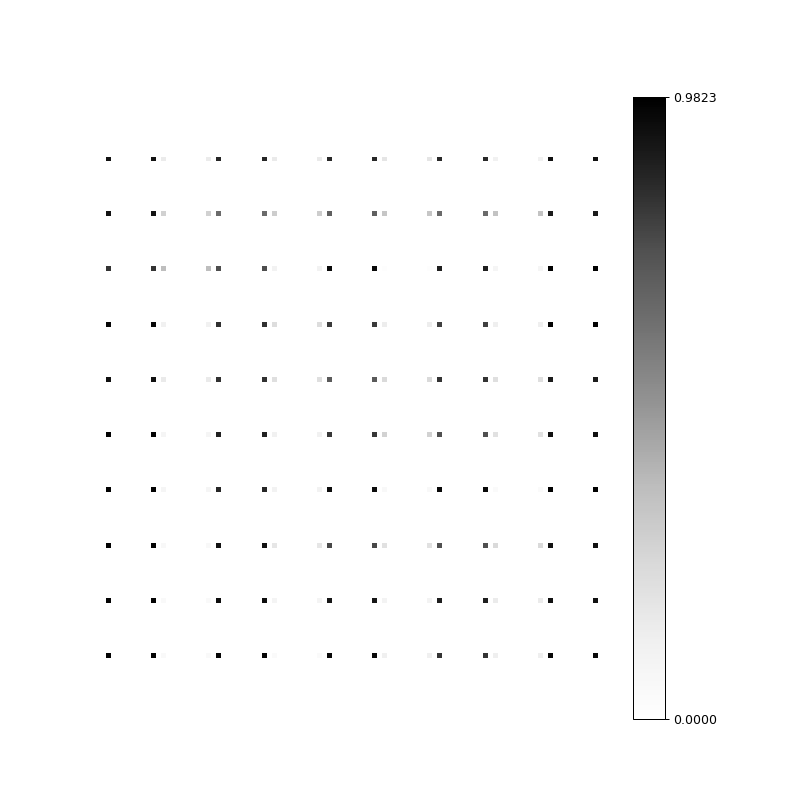

In [82]:
fig = plt.figure(figsize=(10, 10))

draw_weights(lat_ex, Kx, Ky, 10, fig)

Ok, I figured out how to get around the domination problem.  Basically I force the lateral excitation matrix to be symmetric, so you don't get power imbalances.  Now that I got that one figure out, check out that up top!  That's sick.  I'm basically just doing an - 0 - excitation pattern.  You know what?  I'm going to constrain the lateral synapses of a given neuron to be equal.  That might "sew" everything together very nicely.

<IPython.core.display.Javascript object>


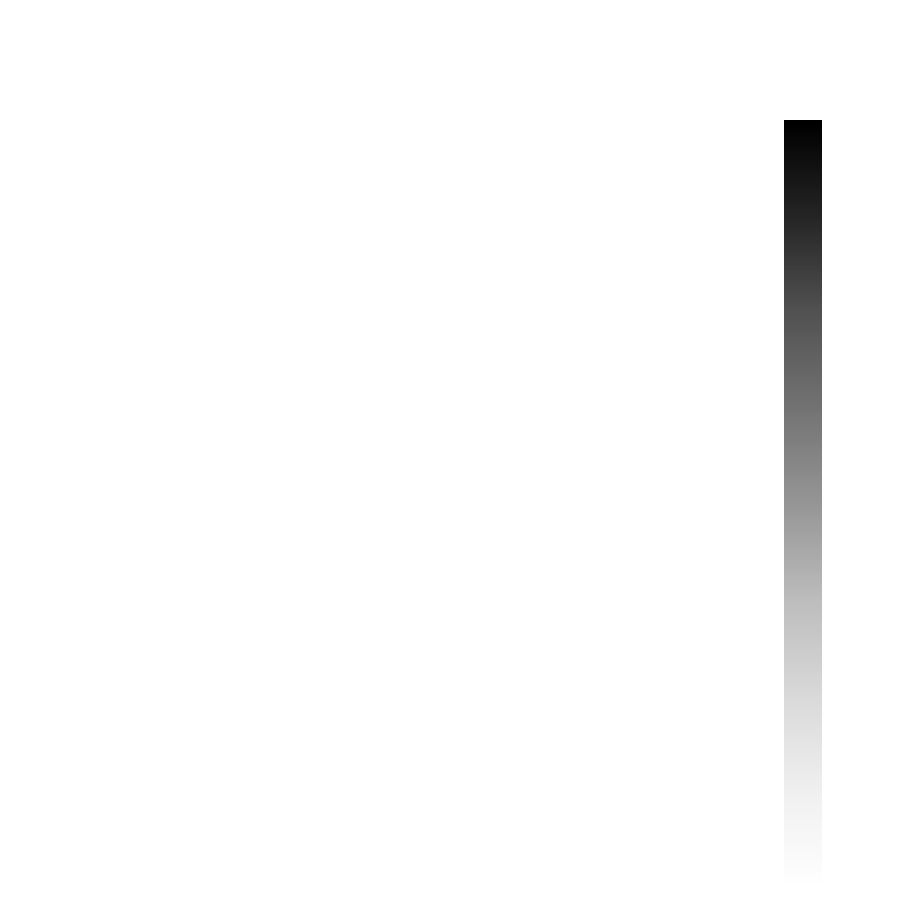

 17%|██████████▎                                                  | 1019/6000 [00:01<00:05, 840.58it/s]c:\users\daniel geisz\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in multiply
c:\users\daniel geisz\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in matmul
c:\users\daniel geisz\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in multiply
100%|█████████████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 897.76it/s]


ValueError: cannot convert float NaN to integer

In [84]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 0    # Vertical neighbor max distance
x_ex = 1    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.001

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.01
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        ff = sig(w_v - t)
        o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
#         o = sig(w_v +((lat_ex - g_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ ff
        mod_o_r = np.maximum(o_r, prec)
        o_e = ff - o_r
        
        lat_ex += lat_ex * ff * (o_e / mod_o_r).T * alpha
        
        lat_ex = 0.5 * (lat_ex + lat_ex.T)
        
        lat_ex = lat_ex_mask * np.linalg.norm(lat_ex, axis=1).reshape(-1, 1)
        
        w /= np.linalg.norm(w, axis=1).reshape(-1, 1)
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

Ok, I guess I'm not going to then.  Instead, I'm going to raise `x_ex`. 

<IPython.core.display.Javascript object>


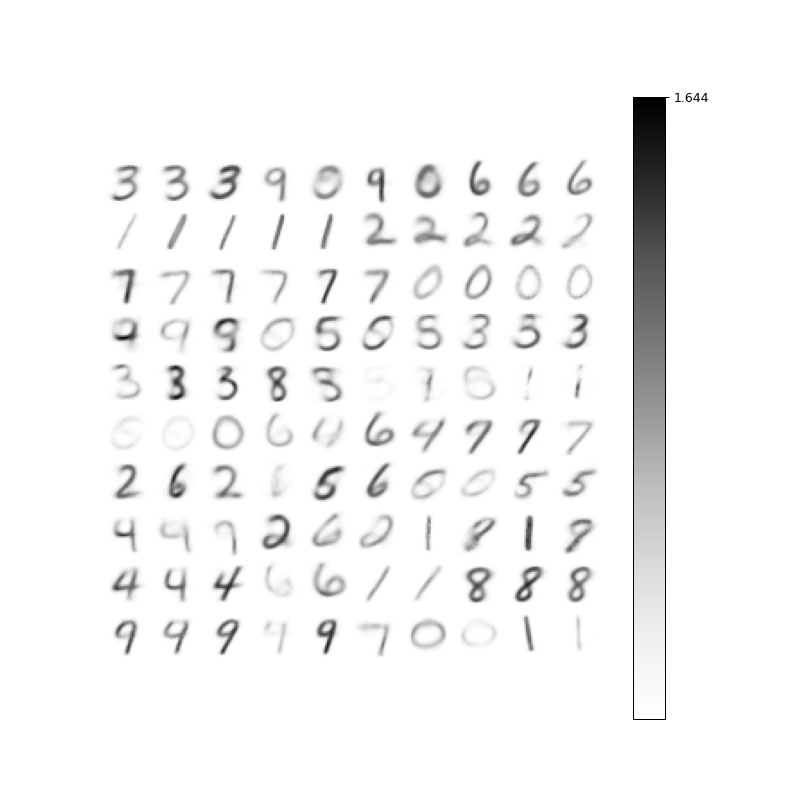

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1191.89it/s]


In [85]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 0    # Vertical neighbor max distance
x_ex = 2    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.001

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.01
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        ff = sig(w_v - t)
        o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
#         o = sig(w_v +((lat_ex - g_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ ff
        mod_o_r = np.maximum(o_r, prec)
        o_e = ff - o_r
        
        lat_ex += lat_ex * ff * (o_e / mod_o_r).T * alpha
        
        lat_ex = 0.5 * (lat_ex + lat_ex.T)
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

Dang.  Now that's pretty cool.  I'm going to bump it one more time.

<IPython.core.display.Javascript object>


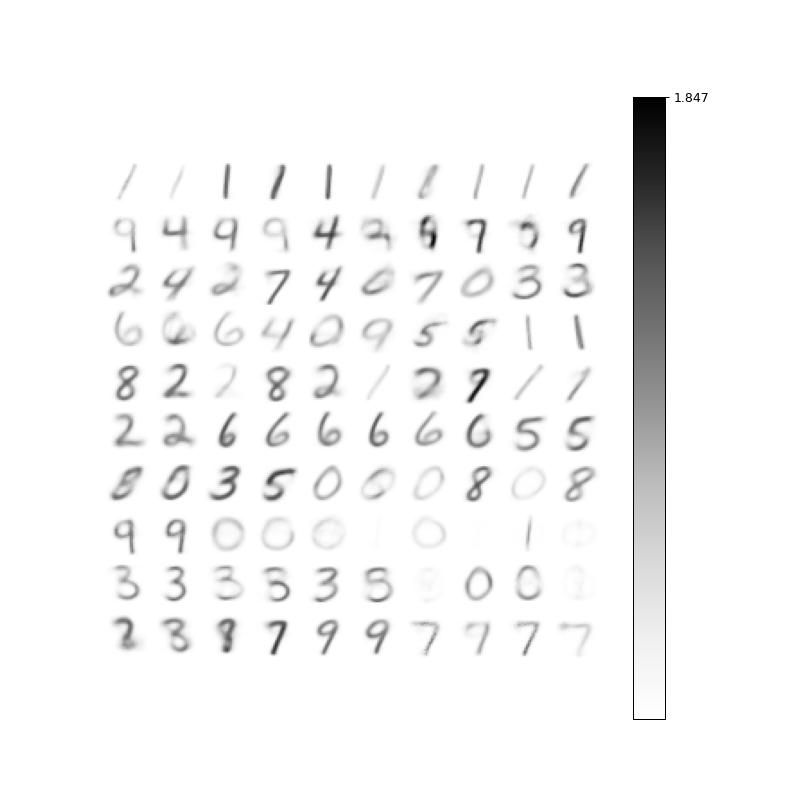

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1192.14it/s]


In [86]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 0    # Vertical neighbor max distance
x_ex = 3    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.001

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.01
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        ff = sig(w_v - t)
        o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
#         o = sig(w_v +((lat_ex - g_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ ff
        mod_o_r = np.maximum(o_r, prec)
        o_e = ff - o_r
        
        lat_ex += lat_ex * ff * (o_e / mod_o_r).T * alpha
        
        lat_ex = 0.5 * (lat_ex + lat_ex.T)
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


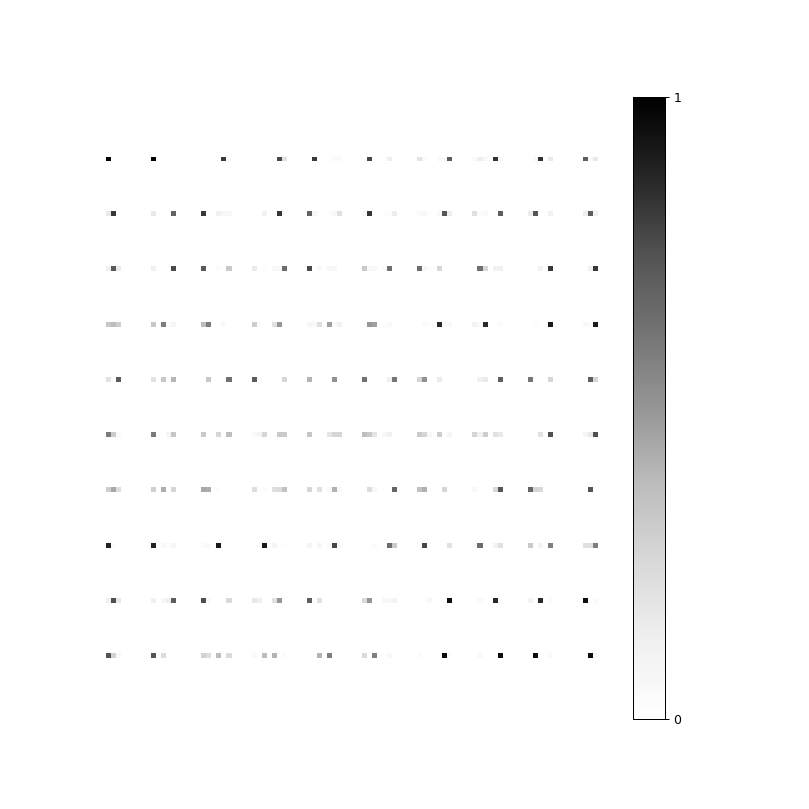

In [87]:
fig = plt.figure(figsize=(10, 10))

draw_weights(lat_ex, Kx, Ky, 10, fig)

Wow.  That's super dope.  I going to bump up the sparsity and see what happens.

<IPython.core.display.Javascript object>


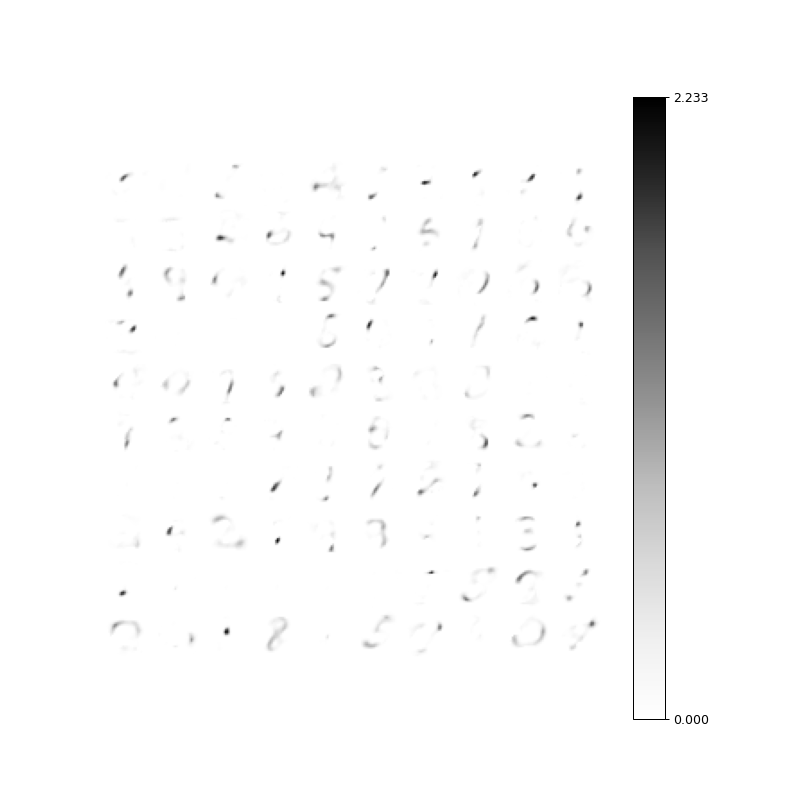

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1141.38it/s]


In [88]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 0    # Vertical neighbor max distance
x_ex = 3    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.001

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.05
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        ff = sig(w_v - t)
        o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
#         o = sig(w_v +((lat_ex - g_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ ff
        mod_o_r = np.maximum(o_r, prec)
        o_e = ff - o_r
        
        lat_ex += lat_ex * ff * (o_e / mod_o_r).T * alpha
        
        lat_ex = 0.5 * (lat_ex + lat_ex.T)
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

I don't really know what to make of that.  I'm going to increase `y_ex` and see what happens.  I'm also decreasing `x_ex`.

<IPython.core.display.Javascript object>


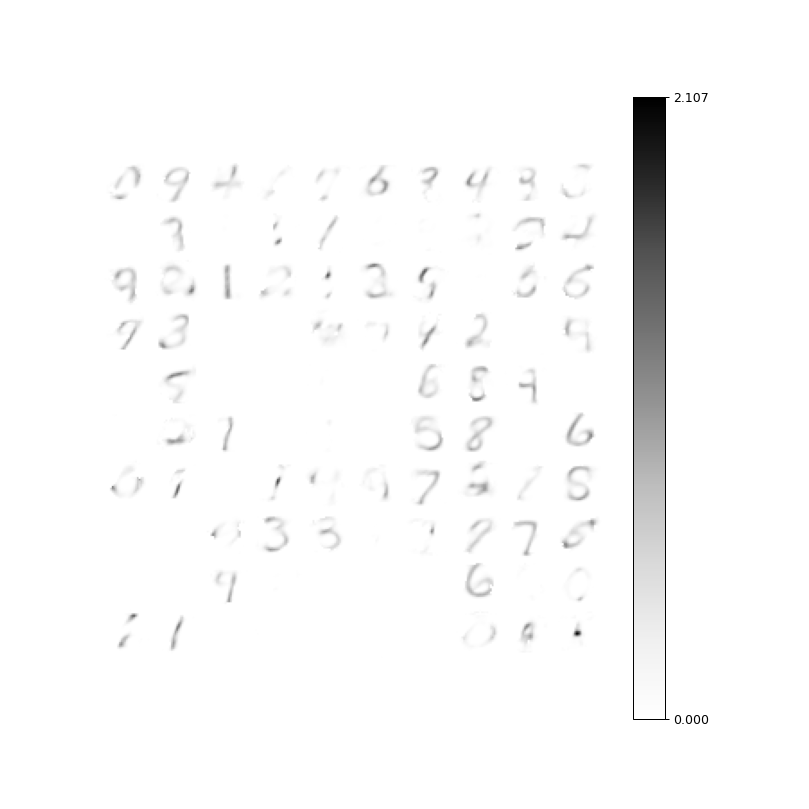

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1184.21it/s]


In [90]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 1    # Vertical neighbor max distance
x_ex = 2    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.001

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.03
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        ff = sig(w_v - t)
        o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
#         o = sig(w_v +((lat_ex - g_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ ff
        mod_o_r = np.maximum(o_r, prec)
        o_e = ff - o_r
        
        lat_ex += lat_ex * ff * (o_e / mod_o_r).T * alpha
        
        lat_ex = 0.5 * (lat_ex + lat_ex.T)
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


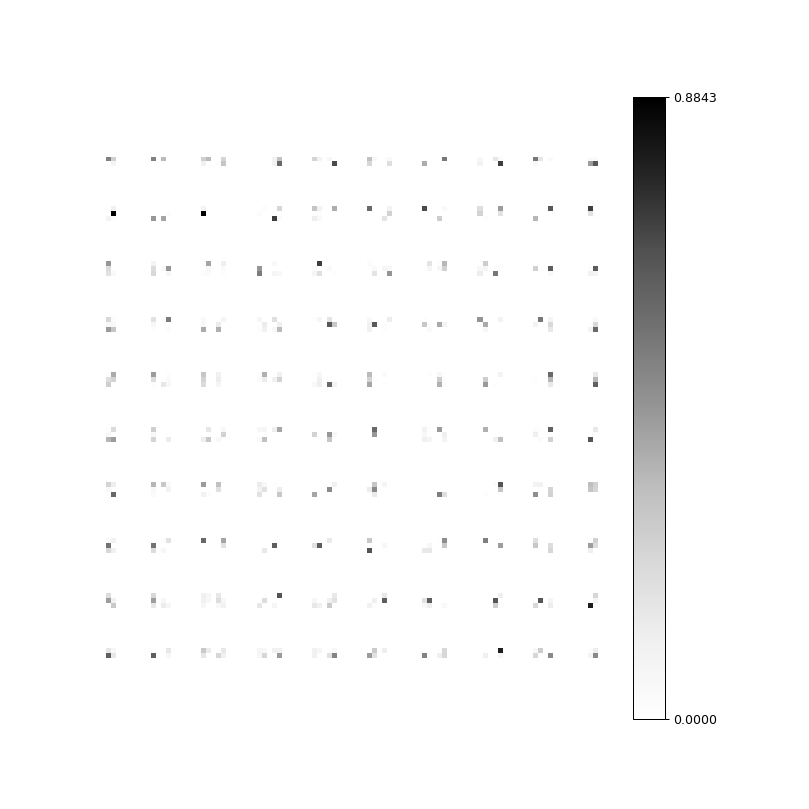

In [91]:
fig = plt.figure(figsize=(10, 10))

draw_weights(lat_ex, Kx, Ky, 10, fig)

I don't even know what to believe.  I'm going to dock the sparsity and keep the excitation terms the same.

<IPython.core.display.Javascript object>


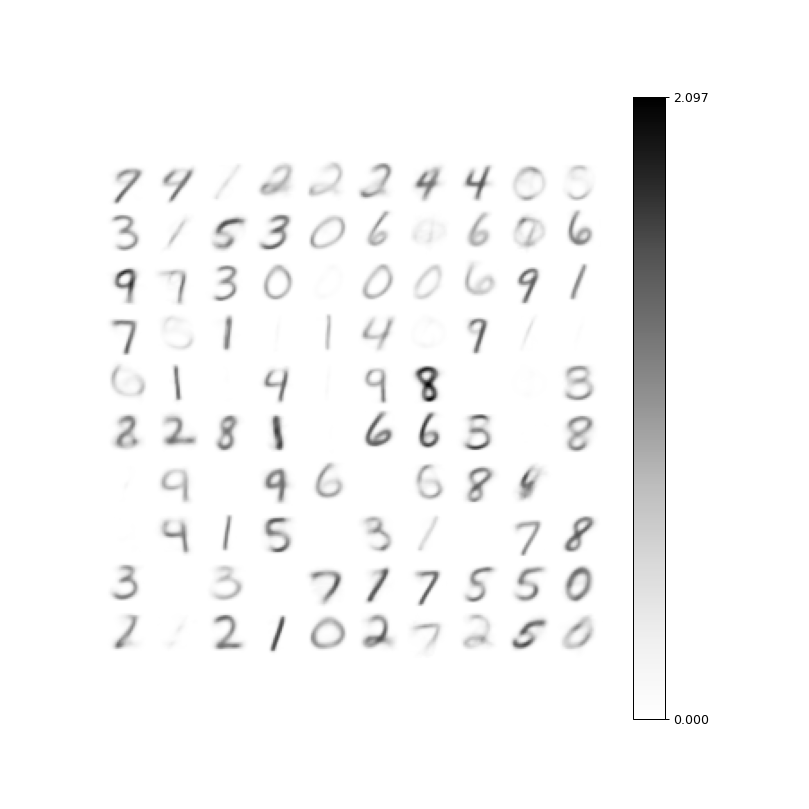

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1171.59it/s]


In [92]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

# Initialize topological excitation
y_ex = 1    # Vertical neighbor max distance
x_ex = 2    # Horizontal neighbor max distance

lat_ex_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), max(x - x_ex, 0): x] = 1
        mask[max(0, y - y_ex): min(y + y_ex + 1, Ky), min(x + 1, Kx): min(x + x_ex + 1, Kx)] = 1
        lat_ex_mask.append(mask.reshape(-1))
        
lat_ex_mask = np.array(lat_ex_mask)
lat_ex = np.random.uniform(0.01, 0.1, (N, N))
lat_ex *= lat_ex_mask


alpha = 0.01

# Initialize global inhibition
g_lat_in = np.zeros((N, N))
np.fill_diagonal(g_lat_in, 0)

beta = 0.001

# Initialize manifold inhibition
m_lat_in_mask = []
for y in range(Ky):
    for x in range(Kx):
        mask = np.zeros((Ky, Kx))
        mask[:, x] = 1
        m_lat_in_mask.append(mask.reshape(-1))
        
m_lat_in_mask = np.array(m_lat_in_mask)
m_lat_in = np.zeros((N, N))
m_lat_in *= m_lat_in_mask

zeta = 0.001 / Ky

# Initialize sparsity threshold
t = np.zeros((N, 1))
gamma = 3
sp = 0.01
sp2 = sp * sp

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        ff = sig(w_v - t)
        o = sig(w_v + ((lat_ex - g_lat_in - m_lat_in) @ w_v) - t)
        
        # Train
        
        # Inhibition
        o_o = (o * o.T) - sp2
        
        # Global inhibition
        g_lat_in += o_o * beta
        np.fill_diagonal(g_lat_in, 0)

        # Manifold inhibition
        m_lat_in += o_o * zeta
        m_lat_in *= m_lat_in_mask
        
        # Feedforward
        r = w.T @ o 
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        # Sparsity threshold
        t += (o - sp) * gamma
        
        # Topological Excitation
        o_r = lat_ex.T @ ff
        mod_o_r = np.maximum(o_r, prec)
        o_e = ff - o_r
        
        lat_ex += lat_ex * ff * (o_e / mod_o_r).T * alpha
        
        lat_ex = 0.5 * (lat_ex + lat_ex.T)
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0.0)
    
    draw_weights(w, Kx, Ky, 28, fig)

The notion of constraining all the lat ex synapses to be equal is very, very tempting.  I think that would sew the inputs together super well.  By constraining all the lat ex synapses to be equal...well wait.  Would that even work?

I need to think about this.

Actually, you know what?  I think lateral excitation should be Hebbian.  There, I said it.  I think Foldiak excitatory neurons.  Yeah.  I think that's the juice.  

It's about dinner time, and this experiment is getting long, so I think it's time to wrap up.

## Conclusions

Goodness, there are a lot of conclusions.  

First things first, make sure you initialize the inhibitory synapses to be zeros.  Otherwise, the network takes forever to learn past the initial stage.

Ok, next up is the effect of domination.  I totally hadn't anticipated this, but if the lateral excitation synapses are trained to reconstruct each other, what happens is that some of the neurons dominate the input of other neurons, which effectively means that the dominated neurons don't learn a feature at all, because they're essentially getting their only input from a lateral connection.

I might actually read a bit to see how V1 gets around that issue.  Anyway, to get around this issue, in the next experiment I'm going to use Foldiak Hebbian synapses for lateral excitation, so neurons only form excitatory connections if they're firing together.  

That being said, I'm somewhat nervous about trying that out, because I don't actually think the excitatory connections will topologically "sew" the features together in the way I had wanted.  I might read Yubei's thesis again and see if I can manufacture the manifold he finds in a natural fashion.  

## Next steps

Topo SparseDream with Hebbian lateral excitatory synapses.  I'm going to do that on both mnist and cifar10, and see what works.